The AB test is a randomized experiment that is used by most large companies to evaluate the launch of new functionality. Various difficulties may arise in the analysis and conduct of the experiment. Several typical problematic cases from real life are given in this dataset and analysis.

### Content
1. [Loading and processing data](#Loading)
2. [Statistical Analysis](#Statistical)
3. [Conclusions](#Conclusions)

### Loading and processing data <a name="Loading"/>

Let's import the necessary libraries and load the data

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import seaborn as sns
from scipy.stats import pearsonr
from scipy.stats import shapiro
import zipfile, io, requests
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# TODO : import the dataset
url = 'https://github.com/devtlv/Datasets-DA-Bootcamp-2-/raw/refs/heads/main/Week%208%20-%20Hackathon%20&%20AB%20Testing/W8D3%20-%20AB%20Testing/AB_Test_Results.zip'
r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.namelist()

['AB_Test_Results/AB_Test_Results.csv']

In [ ]:
# TODO : take a quick look at the data
df = pd.read_csv(z.open('AB_Test_Results/AB_Test_Results.csv'))
display(df.head(10))
df.info()

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0
5,2380,variant,0.0
6,2849,control,0.0
7,9168,control,0.0
8,6205,variant,0.0
9,7548,control,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       10000 non-null  int64  
 1   VARIANT_NAME  10000 non-null  object 
 2   REVENUE       10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB


Let's see if there are users who have two A/B test groups

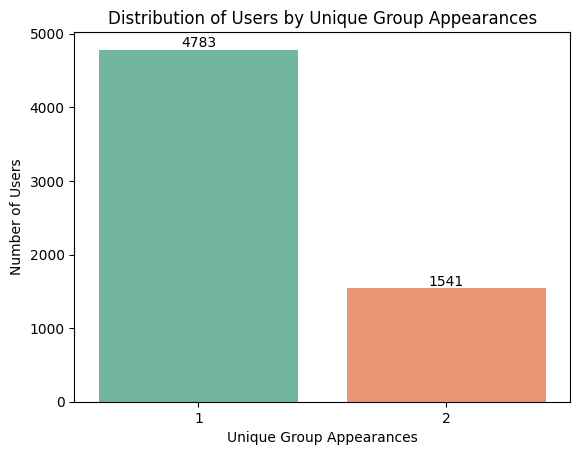

In [ ]:
# TODO : Look at the distribution of the number of unique groups for each user
# Group by User ID -> Extract Number of Unique 'VARIANT_NAMES' for each user
groups = df.groupby('USER_ID')['VARIANT_NAME'].nunique().reset_index()

# value_counts aggregates the count for each group
counts = groups['VARIANT_NAME'].value_counts().sort_index()

# Create bar plot (note x instead of hue)
ax = sns.barplot(x=counts.index, y=counts.values, hue=counts.index, palette='Set2', legend=False)

# Add count labels on top of each bar
for i, v in enumerate(counts.values):
    ax.text(i, v + 0.2, str(v), ha='center', va='bottom')

plt.title("Distribution of Users by Unique Group Appearances")
plt.xlabel("Unique Group Appearances")
plt.ylabel("Number of Users")
plt.show()

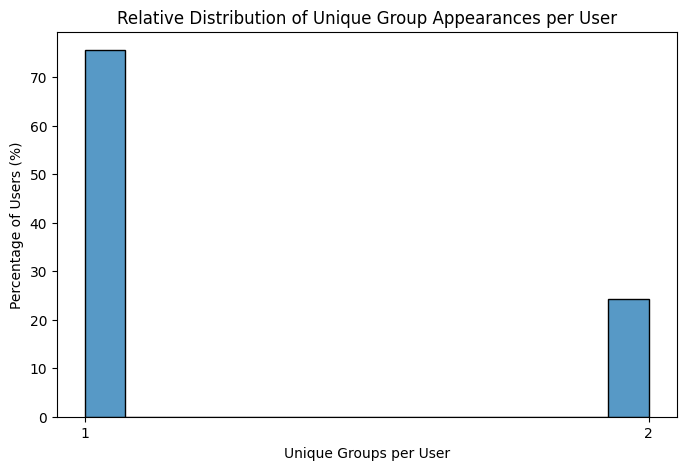

In [ ]:
# TODO : Look at the distribution of the number of unique groups for each user in relative terms
plt.figure(figsize=(8,5))
sns.histplot(groups['VARIANT_NAME'], stat='percent')
plt.xticks(range(1, groups['VARIANT_NAME'].max() + 1)) # Set x-ticks to whole numbers
plt.title("Relative Distribution of Unique Group Appearances per User")
plt.xlabel("Unique Groups per User")
plt.ylabel("Percentage of Users (%)")
plt.show()

In [ ]:
# TODO : Look at the distribution of the number of unique groups for each user in relative terms
rel_counts = groups['VARIANT_NAME'].value_counts(normalize=True).sort_index()
rel_counts

,proportion
VARIANT_NAME,
1,0.756325
2,0.243675


What can you observe ? Should we exclude these users ? Why ?
- ANSWER: Yes, we should exclude these users as it would ensure that the control/treatment group are statistically independent, and that our analysis won't be contaminated by misleading results.

In [ ]:
# TODO : users have 1 A/B test group ?
# Create an Array (of User ID's) that only appear in 1 A/B Group
valid_users = groups[groups['VARIANT_NAME'] == 1]['USER_ID'].values

# TODO : Take only these users
df = df[df['USER_ID'].isin(valid_users)]

# Check
print("Number of Unique Users:", df['USER_ID'].nunique())
df.head()

Number of Unique Users: 4783


,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
4,6174,variant,0.0
5,2380,variant,0.0
7,9168,control,0.0
9,7548,control,0.0


In [ ]:
# TODO : Leave only records with users with the 1st ab test group
# Count of Users Per Group (Control vs Variant)
print(df['VARIANT_NAME'].value_counts(), "\n")

# Split into 2 DF's (Control and Variant)
df_control = df[df['VARIANT_NAME'] == 'control']
df_variant = df[df['VARIANT_NAME'] == 'variant']

# TODO : Check that the number of users matches what it was before the exception
print("Control Count:", df_control.shape[0])
print("Variant Count:", df_variant.shape[0])

VARIANT_NAME
variant    3044
control    3026
Name: count, dtype: int64 

Control Count: 3026
Variant Count: 3044


In [ ]:
df

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
4,6174,variant,0.0
5,2380,variant,0.0
7,9168,control,0.0
9,7548,control,0.0
...,...,...,...
9993,2400,variant,0.0
9994,3129,control,0.0
9996,502,variant,0.0
9998,7741,control,0.0


Let's see how the data is distributed

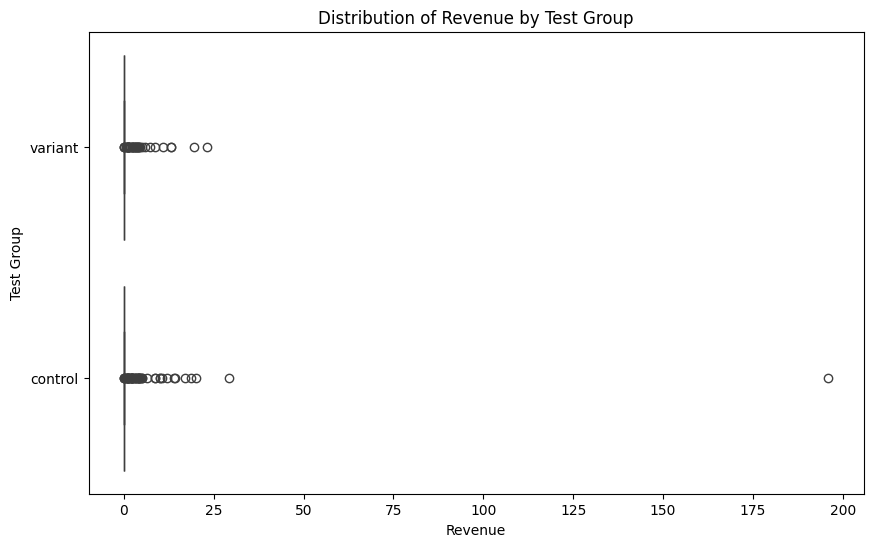

In [ ]:
# TODO : Check how the data is distributed using a box plot
plt.figure(figsize=(10,6))
sns.boxplot(df, y='VARIANT_NAME', x='REVENUE', orient='h')
plt.title('Distribution of Revenue by Test Group')
plt.xlabel('Revenue')
plt.ylabel('Test Group')

plt.show()

It can be seen that there is a strong outlier in the data - we will find it by sorting these revenue values in descending order

In [ ]:
# TODO : Sort these revenue values in descending order
print(df.sort_values(by='REVENUE', ascending=False))

      USER_ID VARIANT_NAME  REVENUE
1437     3342      control   196.01
8168     2166      control    29.32
2482     7356      variant    23.04
6412     1053      control    20.07
5217     3684      variant    19.47
...       ...          ...      ...
3400     9003      variant     0.00
3401     9902      variant     0.00
3403     4863      control     0.00
3404     1807      control     0.00
3438     4636      control     0.00

[6070 rows x 3 columns]


In [ ]:
# TODO : See if user 3342 had other events with a strong outlier
print(df[df['USER_ID'] == 3342])

      USER_ID VARIANT_NAME  REVENUE
1437     3342      control   196.01


We see that there is only one outlier - in conditions of limited information, we will remove this entry and look at the distribution of data again

In [ ]:
# TODO : We see that there is only one outlier - in conditions of limited information, remove this entry and visualize the distribution of data again.
df = df[df['USER_ID'] != 3342]
df_control = df[df['VARIANT_NAME'] == 'control']
df_variant = df[df['VARIANT_NAME'] == 'variant']

# Check
df_control.shape[0]


3025


What can you say about the users and their purchases ?

In [ ]:
# TODO : Check if there are users who have records with zero and positive revenue
# Group by User ID -> Count how many events each user had -> Show their min/max revenue to see difference
zero_pos = df_control.groupby('USER_ID')['REVENUE'].agg(['count', 'min', 'max'])

# Filter to Show Users with Count Higher than 1
zero_pos = zero_pos[zero_pos['count'] > 1]

# Filter to show users who have records with zero and positive revenue
zero_pos = zero_pos[(zero_pos['min'] == 0) & (zero_pos['min'] != zero_pos['max'])]

# Check and Order by User ID
display(zero_pos.sort_index())

,count,min,max
USER_ID,,,
124,3,0.0,1.25
169,2,0.0,4.33
282,2,0.0,18.56
487,2,0.0,4.33
868,2,0.0,4.27
1035,2,0.0,0.23
1053,4,0.0,20.07
1883,2,0.0,4.33
1939,2,0.0,1.56


Can a user have records with both zero and positive revenue ?
- ANSWER: Yes

Let's make the assumption that the records are user visits to the service, and the experimental unit is users.


In [ ]:
# TODO : Group the data for each user and sum the revenue for each to get one record per user
revenues = df_control.groupby('USER_ID')['REVENUE'].sum()

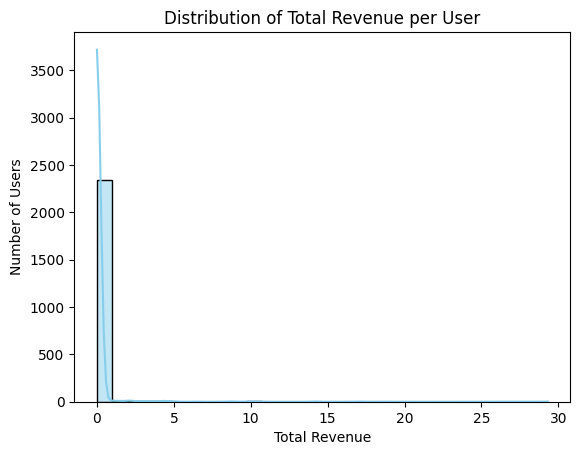

In [ ]:
# TODO : Visualize the resulting distribution of the data again.
sns.histplot(revenues, bins=30, kde=True, color='skyblue')
plt.title('Distribution of Total Revenue per User')
plt.xlabel('Total Revenue')
plt.ylabel('Number of Users')
plt.show()

It should be noted that during the transformation, the quantiles in the test group increased

It can be seen that in the test group, almost all quantile statistics, except for the minimum, are at a slightly lower level.

Let's look at various statistics in the context of AB test groups for all users

In [ ]:
# TODO : get metrics by groups
# Mean and Median for Each Group
control_mean = df_control['REVENUE'].mean()
variant_mean = df_variant['REVENUE'].mean()

# TODO : create two additional metrics to see relative changes
abs_change = variant_mean - control_mean
rel_change = (variant_mean - control_mean) / control_mean * 100


# TODO : add them to the rest of the metrics in a separate group
metrics = pd.DataFrame({
    'Metric' : ['Mean'],
    'Control' : [control_mean],
    'Variant' : [variant_mean],
    'Abs. Change' : [abs_change],
    'Rel. Change' : [rel_change]
})

metrics

,Metric,Control,Variant,Abs. Change,Rel. Change
0,Mean,0.09076,0.058909,-0.031851,-35.093527


What can you see in the test group about the total amount of revenue, the average check per user, and the number of orders per user slightly increased ?

Let's also see how paying users behave :

In [ ]:
# TODO : get metrics by groups
# Total Revenue
control_total = df_control['REVENUE'].sum()
variant_total = df_variant['REVENUE'].sum()

# TODO : create two additional metrics to see relative changes
abs_change = variant_total - control_total
rel_change = (variant_total - control_total) / control_total * 100

# TODO : add them to the rest of the metrics in a separate group
new_row = ['Total Revenue', control_total, variant_total, abs_change, rel_change]
metrics.loc[len(metrics)] = new_row

# Check
metrics


,Metric,Control,Variant,Abs. Change,Rel. Change
0,Mean,0.09076,0.058909,-0.031851,-35.093527
1,Total Revenue,274.55000,179.320000,-95.230000,-34.685850


In [ ]:
# Average Checks per User
control_mean_count = df_control.groupby('USER_ID')['USER_ID'].agg('count').mean()
variant_mean_count = df_variant.groupby('USER_ID')['USER_ID'].agg('count').mean()

# TODO : create two additional metrics to see relative changes
abs_change = variant_mean_count - control_mean_count
rel_change = (variant_mean_count - control_mean_count) / control_mean_count * 100

# TODO : add them to the rest of the metrics in a separate group
new_row = ['Avg. Checks', control_mean_count, variant_mean_count, abs_change, rel_change]
metrics.loc[len(metrics)] = new_row

# Check
metrics

,Metric,Control,Variant,Abs. Change,Rel. Change
0,Mean,0.09076,0.058909,-0.031851,-35.093527
1,Total Revenue,274.55000,179.320000,-95.230000,-34.685850
2,Avg. Checks,1.26622,1.272043,0.005823,0.459895


Let's look at the distributions of all and only paying users

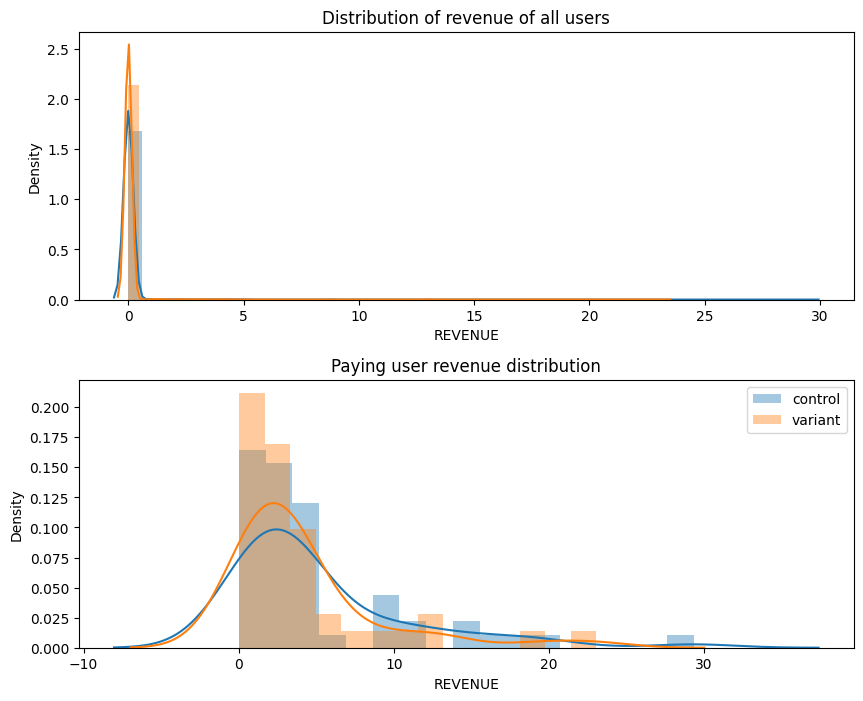

In [ ]:
f, axes = plt.subplots(2, figsize=(10,8))
# build graphs of distributions of all users
sns.distplot(df.loc[df['VARIANT_NAME'] == 'control', 'REVENUE'], ax = axes[0], label='control')
sns.distplot(df.loc[df['VARIANT_NAME'] == 'variant', 'REVENUE'], ax = axes[0], label='variant')
axes[0].set_title('Distribution of revenue of all users')

# build graphs of distributions of paying users
sns.distplot(df.loc[(df['VARIANT_NAME'] == 'control') & (df['REVENUE'] > 0), 'REVENUE'], ax = axes[1], label='control' )
sns.distplot(df.loc[(df['VARIANT_NAME'] == 'variant') & (df['REVENUE'] > 0), 'REVENUE'], ax = axes[1], label='variant' )
axes[1].set_title('Paying user revenue distribution')
plt.legend()
plt.subplots_adjust(hspace = 0.3)

### Statistical Analysis <a name="Statistical"/>

#### Checking if the distribution is normal

Based on their previous graph, we see that the data is not normally distributed.

In [ ]:
# TODO : Use the Shapiro-Wilk criterion to confirm it
# CONTROL GROUP
stat, p = shapiro(df_control['REVENUE'])
print(f'Control W-statistic: {stat:.4f}')
print(f'Control p-value: {p:.2f}')

if p > 0.05:
    print("Control Data is likely normal\n")
else:
    print("Control Data is not normal\n")

# VARIANT Group
stat, p = shapiro(df_variant['REVENUE'])
print(f'Control W-statistic: {stat:.4f}')
print(f'Control p-value: {p:.2f}')

if p > 0.05:
    print("Variant Data is likely normal")
else:
    print("Variant Data is not normal")

Control W-statistic: 0.0622
Control p-value: 0.00
Control Data is not normal

Control W-statistic: 0.0510
Control p-value: 0.00
Variant Data is not normal


Is the null hypothesis about the normal distribution of the data rejected ?
- Given that the P-Value is below 5% for both the control and variant groups, we can reject the null hypothesis and confirm that they are NOT normally distributed

#### Mann-Whitney test

Let's check the value of the statistics of the Mann-Whitney test. Some sources have a limitation of applicability in case of duplicate data. There are a lot of repetitions in our sample, and especially a lot of zero values, so in this case we need to be careful about this criterion.

In [ ]:
(df['REVENUE'] == 0).value_counts()

,count
REVENUE,
True,5973
False,96


In [ ]:
from sklearn.utils import resample
# TODO : Check on the data of all users the value of the statistics of the Mann-Whitney test
# Prepare Data
x = df_control['REVENUE'].values
y = df_variant['REVENUE'].values

# Mann-Whitney U Test
u_statistic, p_value = mannwhitneyu(x, y)
print(f"Mann-Whitney U Test: U={u_statistic}, p-value={p_value}")

# Bootstrap method for difference in means
diffs = []
for _ in range(10000):
    sample_A = resample(x)
    sample_B = resample(y)
    diff = np.mean(sample_B) - np.mean(sample_A)
    diffs.append(diff)

confidence_interval = np.percentile(diffs, [2.5, 97.5])
print(f"95% Confidence Interval for the difference in means: {confidence_interval}")

Mann-Whitney U Test: U=4619788.0, p-value=0.2859842308619548
95% Confidence Interval for the difference in means: [-0.07776828  0.01262394]


- **Conclusion for Analysis (ALL USERS)**: The variant does not show a statistically significant difference in revenue compared to the control. We should stay with the control method.

  - The large U-statistic simply reflects that there are a lot of data points, and when groups are similar, U will be around 50% (4.6m/9m) of its maximum possible value. Combined with the high p-value and confidence interval containing zero, all evidence points to no meaningful difference between the groups.

In [ ]:
# TODO : Check on the data of only the users that pay, the value of the statistics of the Mann-Whitney test
# Filter to Include only users that pay
df_pay = df[df['REVENUE'] > 0]

# Extract Relevent Data
x = df_pay[df_pay['VARIANT_NAME'] == 'control']['REVENUE'].values
y = df_pay[df_pay['VARIANT_NAME'] == 'variant']['REVENUE'].values

# Mann-Whitney U Test
u_statistic, p_value = mannwhitneyu(x, y)
print(f"Mann-Whitney U Test: U={u_statistic}, p-value={p_value}")

# Bootstrap method for difference in means
diffs = []
for _ in range(10000):
    sample_A = resample(x)
    sample_B = resample(y)
    diff = np.mean(sample_B) - np.mean(sample_A)
    diffs.append(diff)

confidence_interval_paid = np.percentile(diffs, [2.5, 97.5])
print(f"95% Confidence Interval for the difference in means: {confidence_interval_paid}")

Mann-Whitney U Test: U=1249.0, p-value=0.4218148352342157
95% Confidence Interval for the difference in means: [-3.11672685  1.13793978]


The U-statistic represents the **number of times a value from one group is greater than a value from the other group** (when comparing all possible pairs).

**Conclusion for Analysis (PAYING USERS)**: Given that the U-Statistic is close to 50% of the its maximum value, it means that half of the times, revenue was higher for the control, and the other half it was higher for the variant. This means that the outcomes were quite random. Additionally, the high P-Value as well as 0 (indicating absolute difference between the 2 sets) being within the range of the confidence interval, we can confidently say that there is no statistical difference between the two groups.

#### Bootstrap

In order to get more complete information about the differences between the average values of the ab test groups, we will use bootstap.

Let's create a function to get back samples and get a confidence interval, and then look at the sample statistics

In [ ]:
def get_bootstrap_samples(data, n_samples=1000):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha=0.05):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [ ]:
# TODO : Generate samples for all users
control = get_bootstrap_samples(df_control['REVENUE'].values)
variant = get_bootstrap_samples(df_variant['REVENUE'].values)

In [ ]:
# TODO : Generate samples for only paying users
control_paid = get_bootstrap_samples(df_pay[df_pay['VARIANT_NAME'] == 'control']['REVENUE'].values)
variant_paid = get_bootstrap_samples(df_pay[df_pay['VARIANT_NAME'] == 'variant']['REVENUE'].values)

Let's look at the distribution of means in the ab test groups

Text(0.5, 1.0, 'Sample mean distribution for all users')

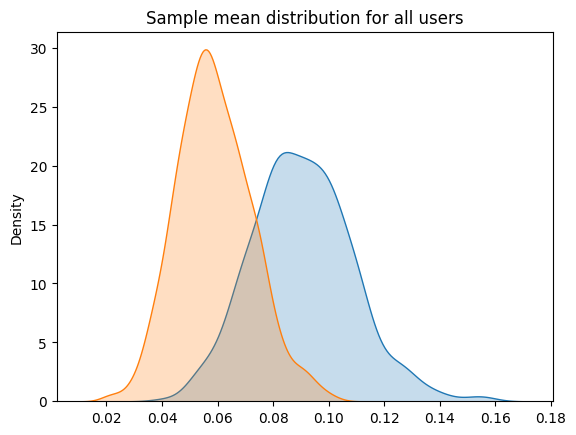

In [ ]:
f, ax = plt.subplots()
# plt.figure(figsize=(20,5))
sns.kdeplot(np.mean(control, axis=1), shade=True, label='control')
sns.kdeplot(np.mean(variant, axis=1), shade=True, label='variant')
plt.title('Sample mean distribution for all users')

Text(0.5, 1.0, 'Sample mean distribution for paying users')

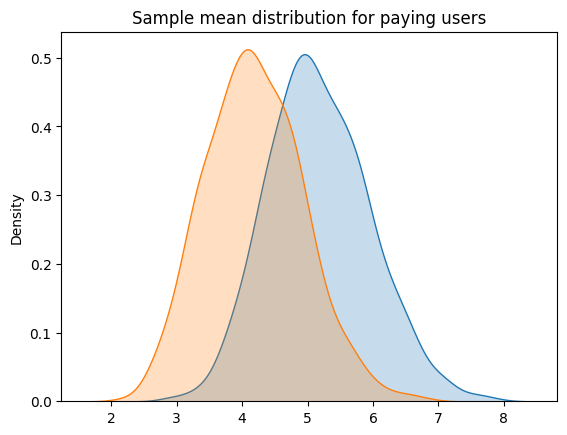

In [ ]:
f, ax = plt.subplots()
# plt.figure(figsize=(20,5))
sns.kdeplot(np.mean(control_paid, axis=1), shade=True, label='control')
sns.kdeplot(np.mean(variant_paid, axis=1), shade=True, label='variant')
plt.title('Sample mean distribution for paying users')

In [ ]:
# Confidence Intervals
# Calculate the statistic for each bootstrap sample
control_mean = np.mean(control, axis=1)
variant_mean = np.mean(variant, axis=1)

# Calculate Difference of Means
diffs = variant_mean - control_mean

# Create Confidence Interval Using Provided Function
ci = stat_intervals(diffs, alpha=0.05)

# REPEAT FOR Paying Customers Only
# Calculate the statistic for each bootstrap sample
control_payed_mean = np.mean(control_paid, axis=1)
variant_payed_mean = np.mean(variant_paid, axis=1)

# Calculate Difference of Means
diffs_payed = variant_payed_mean - control_payed_mean

# Create Confidence Interval Using Provided Function
ci_payed = stat_intervals(diffs_payed, alpha=0.05)

print(f"Confidence Interval at 95% (All Users): [{ci[0]:.4f}, {ci[1]:.4f}]")
print(f"Confidence Interval at 95% (Paying Users): [{ci_payed[0]:.4f}, {ci_payed[1]:.4f}]")

Confidence Interval at 95% (All Users): [-0.0774, 0.0113]
Confidence Interval at 95% (Paying Users): [-3.2138, 1.1621]


Do you see any difference ? What about the confidence intervals ? Conclude.
- **ANSWER**: Though we may see that there seems to be a clear difference between the sample means of the control and variant groups, there is also a significant overlap of the two distributions, which is crucial. This overlap translates to uncertainty about whether the difference is real or just noise.

- The confidence interval represents the range of absolute differences in means between the two groups at 95% confidence. Since 0 is included in our confidence interval range, we can't be confident that there is a real effect on Revenue between the two groups.

Let's evaluate the difference between the groups: look at the distribution of the mean difference and build confidence intervals for it. To do this, we will create a function for visualization

In [ ]:
def plot_distribution_and_stat_intervals(variant, control, title, alpha=0.05):
    """ Plot the distribution of the mean difference and return the confidence intervals """
    from scipy import stats

    f, ax = plt.subplots()

    # Calculate the difference
    diff = variant - control

    # Manually compute KDE
    kde = stats.gaussian_kde(diff)
    x = np.linspace(diff.min(), diff.max(), 1000)
    y = kde(x)

    # Plot the KDE
    ax.plot(x, y)
    ax.fill_between(x, y, alpha=0.3)

    ymin, ymax = plt.ylim()

    # Calculate confidence intervals
    ci = stat_intervals(diff, alpha)

    # highlight the zero value and the bounds of the confidence interval
    plt.vlines(0, 0, ymax, label='0', color='gray', linewidth=2)
    plt.vlines(ci[0], 0, ymax, linestyles="dashed", linewidth=2)
    plt.vlines(ci[1], 0, ymax, linestyles="dashed", linewidth=2)

    # color the confidence interval and zones outside it
    plt.fill_between(x, y,
                     where=(x >= ci[1]),
                     color='gainsboro',
                     alpha=0.5)
    plt.fill_between(x, y,
                     where=(x <= ci[0]),
                     color='gainsboro',
                     alpha=0.5)
    plt.fill_between(x, y,
                     where=((x >= ci[0]) & (x <= ci[1])),
                     color='red',
                     alpha=0.5,
                     label='95% confidence interval')

    plt.xlabel('Difference in Means (Variant - Control)')
    plt.ylabel('Density')
    plt.title(f'Distribution of difference between means (variant - control) {title};\n{100*(1-alpha)}% Confidence interval: {ci}')
    plt.legend(prop={'size': 13})

    # return confidence interval data
    return ci

Let's build a graph of the distribution of the difference in the means and get a confidence interval

For all users

Confidence Interval: [-0.07736872  0.01130971]


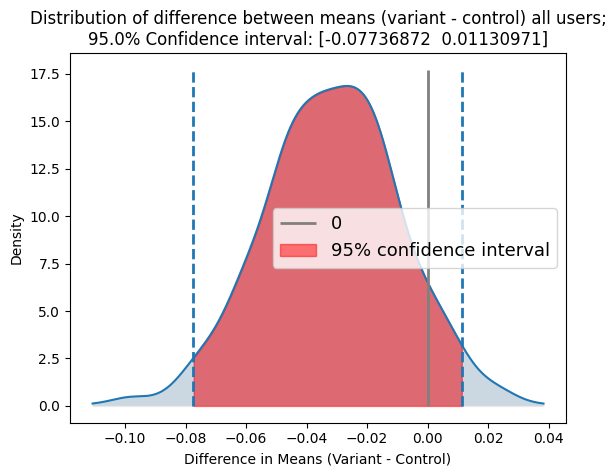

In [ ]:
ci = plot_distribution_and_stat_intervals(np.mean(variant, axis=1),
                                          np.mean(control, axis=1),
                                          title='all users')
print(f"Confidence Interval: {ci}")

Confidence Interval: [-3.21379081  1.16210312]


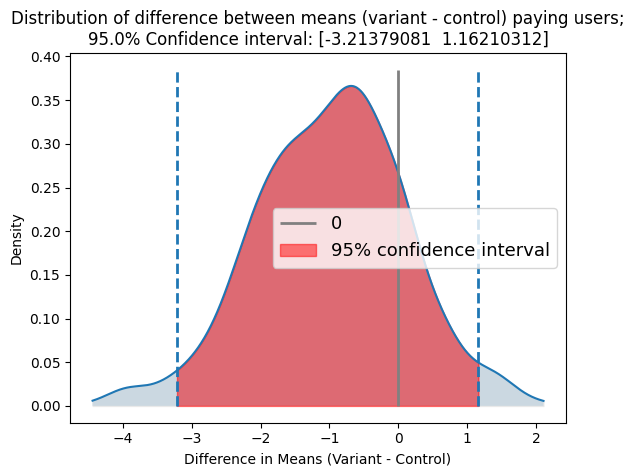

In [ ]:
ci = plot_distribution_and_stat_intervals(np.mean(variant_paid, axis=1),
                                          np.mean(control_paid, axis=1),
                                          title='paying users')
print(f"Confidence Interval: {ci}")

### OTHER METHOD

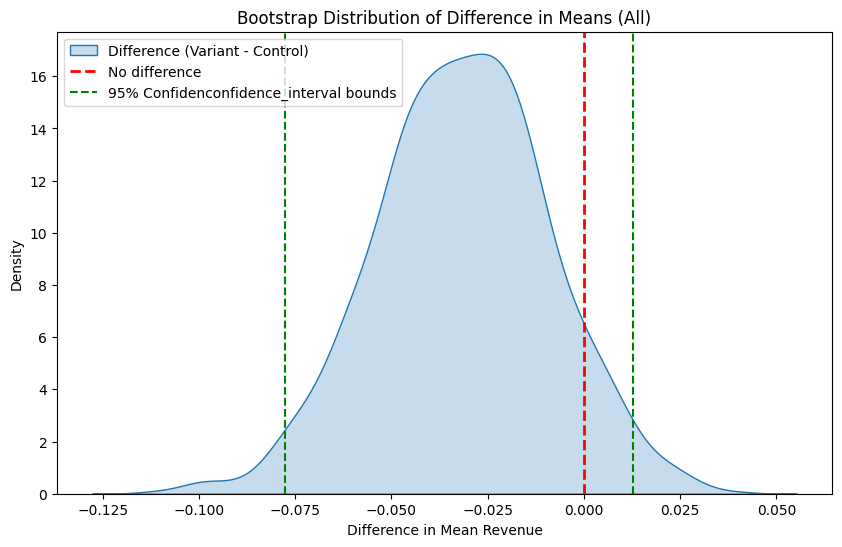

Proportion of bootstrap samples where difference > 0: 8.20%


In [ ]:
# Calculate differences for each bootstrap sample
diffs = np.mean(variant, axis=1) - np.mean(control, axis=1)

# Plot the distribution of differences
plt.figure(figsize=(10, 6))
sns.kdeplot(diffs, shade=True, label='Difference (Variant - Control)')
plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label='No difference')
plt.axvline(x=confidence_interval[0], color='green', linestyle='--', label='95% Confidenconfidence_interval bounds')
plt.axvline(x=confidence_interval[1], color='green', linestyle='--')
plt.xlabel('Difference in Mean Revenue')
plt.ylabel('Density')
plt.title('Bootstrap Distribution of Difference in Means (All)')
plt.legend()
plt.show()

print(f"Proportion of bootstrap samples where difference > 0: {(diffs > 0).mean():.2%}")

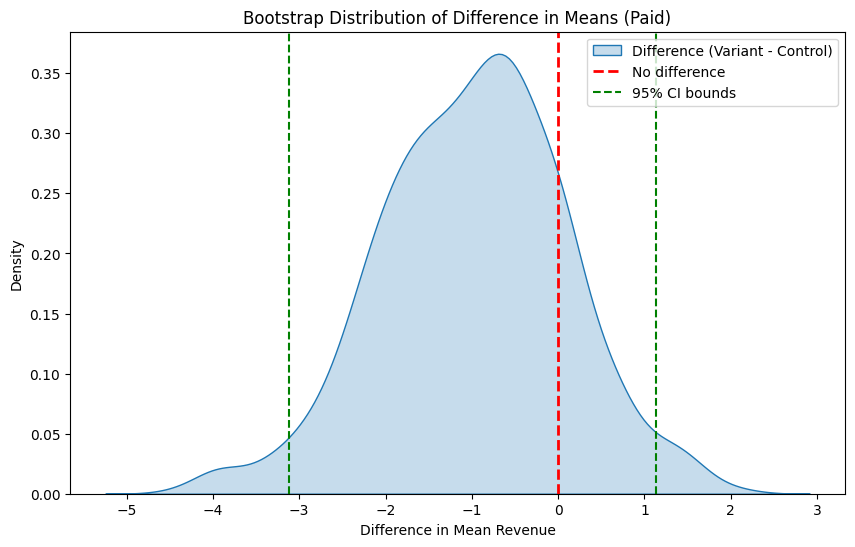

Proportion of bootstrap samples where difference > 0: 17.60%


In [ ]:
# Calculate differences for each bootstrap sample
diffs = np.mean(variant_paid, axis=1) - np.mean(control_paid, axis=1)

# Plot the distribution of differences
plt.figure(figsize=(10, 6))
sns.kdeplot(diffs, shade=True, label='Difference (Variant - Control)')
plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label='No difference')
plt.axvline(x=confidence_interval_paid[0], color='green', linestyle='--', label='95% CI bounds')
plt.axvline(x=confidence_interval_paid[1], color='green', linestyle='--')
plt.xlabel('Difference in Mean Revenue')
plt.ylabel('Density')
plt.title('Bootstrap Distribution of Difference in Means (Paid)')
plt.legend()
plt.show()

print(f"Proportion of bootstrap samples where difference > 0: {(diffs > 0).mean():.2%}")

What can you observe ? Conclude about the statistical change in average revenue between A/B test groups.

- **ANSWER**: They are extremely similar, meaning there is NO statistically significant change in average revenue between the A/B test groups.
